In [23]:
import numpy as np
import torch
import torch.utils.data as utils
from albumentations import (HorizontalFlip, VerticalFlip)
import random
import torchvision.transforms.functional as TF
import PIL.Image as Image
import matplotlib.pyplot as plt
import time
import nibabel as nib
now=time.localtime(time.time())

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,i,data_path, augmentation=True):
        self.data_path = data_path
        self.data = np.load(data_path+'MRimages_{}.npy'.format(i))
        self.target = np.load(data_path+'MASK_{}.npy'.format(i))
        self.augmentation = augmentation
        print(self.data.shape)
        print(self.target.shape)
        
    def __getitem__(self, index):
        x= self.data[index]
        y = self.target[index]
        x,y=self.transform(x,y)
        
        return x,y
    
    def transform(self, data, target):
        data, target = data_augmentation(data, target, self.augmentation)
        return data, target
    
    def __len__(self):
        return len(self.data)


In [3]:
def data_augmentation(image, labels, aug=True):
    a= random.random()
    image = Image.fromarray(image)
    mask = Image.fromarray(labels)
    if aug :
        if a > 0.5 :
            augmentated = HorizontalFlip(p=1)(image=np.array (image), mask=np.array(mask))
            image = Image.fromarray(augmentated['image'])
            mask = Image.fromarray(augmentated['mask'])
    data = TF.to_tensor(np.array(image)).float()
    masks = TF.to_tensor(np.array(mask)).float()
    return data, masks

In [19]:
train_datasets=[]
test_datasets=[]

for i in range(5):
    i+=1
    train_datasets.append(Dataset(i,'C:/Users/BMPL/Desktop/data set/', augmentation = True))
    if i == 5 : 
        test_datasets.append(Dataset(i,'C:/Users/BMPL/Desktop/data set/', augmentation = False))

traindataset = torch.utils.data.ConcatDataset(train_datasets)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size =4, shuffle = True, num_workers=0, pin_memory=False)

testdataset = torch.utils.data.ConcatDataset(test_datasets)
testloader = torch.utils.data.DataLoader(testdataset, batch_size =1, shuffle = False, num_workers=0, pin_memory=False)


(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)


In [5]:
'''
for batch_idx,(data,target) in enumerate(trainloader):
    inputs, target = data, target
    inputs=inputs.squeeze()
    target=inputs.squeeze()
    print('inputs=%s'%str(inputs.shape))
    print('target=%s'%str(target.shape))
#f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')
#print(inputs[0][0])
#f.write(inputs[0][0])
'''

"\nfor batch_idx,(data,target) in enumerate(trainloader):\n    inputs, target = data, target\n    inputs=inputs.squeeze()\n    target=inputs.squeeze()\n    print('inputs=%s'%str(inputs.shape))\n    print('target=%s'%str(target.shape))\n#f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')\n#print(inputs[0][0])\n#f.write(inputs[0][0])\n"

In [6]:
'''f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')
line=''
enter='\n'
space=' '
for i in list(inputs[0][0]):
    line=''
    for j in list(i):
        line+=str(int(j))
        line+=space
    line+=enter
    f.write(line)'''

"f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')\nline=''\nenter='\n'\nspace=' '\nfor i in list(inputs[0][0]):\n    line=''\n    for j in list(i):\n        line+=str(int(j))\n        line+=space\n    line+=enter\n    f.write(line)"

In [7]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model     

In [9]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn) # 필터갯수를 두개씩 늘린다. 
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn) #이게 업 스케일링 하는 거다. 
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn) # 이게 옆에있는 친구 끌고와서 같이 컴볼루젼 하는것, res 넷의 핵심 
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)
        
        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1))
           # nn.Softmax(dim=1))  #필수는 아님 시그모이드 함수와 유사하지만, -1~1까지 출력 범위하는 것이 다르다. '''
        
            
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [10]:
img_size = 256 # 이건 나중에 수정 해야함. 하드코딩은 안돼요. 
in_dim = 1 # 데이터 한개의 채널 개수. MR은 흑백 이미지 이므로 채널이 한개이다. 
out_dim = 6 # 총 분할해야 하는 클래스의 개수. 일단 여기서는 6종류 이므로 6개 이다. 
num_filters = 64 # 필터개수 
num_epoch = 100 # 트례이님 횟수 
lr = 0.1 # learning rate
total_batch = len(trainloader)

print('총 배치의 수 : {}'.format(total_batch))

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)

# 손실함수 및 최적화함수를 설정합니다.
#loss_func = nn.MSELoss()
loss_func =  nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99)
optimizer =  torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = 1e-3)# lr = learning rate

for i in range(num_epoch):
    avg_cost = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        x, y = data.to(device), target.squeeze().to(device=device, dtype=torch.int64)
        # x= [4,1,256,256], y= [4,256,256] , output = [4,6,256,256]
       # y=y.squeeze()
        optimizer.zero_grad()
        
        output = model.forward(x)
        output_label = torch.argmax(output, dim=1)
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
       
        
        
        '''if batch_idx == 25: 
            zeros=np.zeros((256,256,1))
            x_sample=x[0][0].cpu()/256
            y_sample=y[0].cpu()*50/256
            output_sample=output_label[0].cpu()*50/256 
        
            x_sample2=np.reshape(x_sample, (256, 256, 1))
            y_sample2=np.reshape(y_sample, (256, 256, 1))
            ouput_sample2 = np.reshape(output_sample,(256,256,1))

            x_image=np.concatenate((x_sample2, x_sample2, x_sample2), axis = 2)
            y_image=np.concatenate(( zeros, y_sample2,  zeros), axis = 2)
            output_image=np.concatenate(( zeros, ouput_sample2, zeros), axis = 2)
        
            origin_image = x_image+y_image
            AI_image = x_image+output_image

            plt.subplot(131)
            plt.imshow(x_image)
            plt.subplot(132)
            plt.imshow(y_image)
            plt.subplot(133)
            plt.imshow(output_image)
        
            plt.savefig('C:/Users/BMPL/Desktop/auto_seg_png/test_{}.png'.format(i) , dpi=300)
            plt.show()'''
        
    print('[Epoch: {:>4}] cost = {:>.9}'.format(i + 1, avg_cost))
    



총 배치의 수 : 320

------Initiating U-Net------

[Epoch:    1] cost = 0.433567822
[Epoch:    2] cost = 0.100640886
[Epoch:    3] cost = 0.0797292888
[Epoch:    4] cost = 0.0752685368
[Epoch:    5] cost = 0.0703452453
[Epoch:    6] cost = 0.0676926449
[Epoch:    7] cost = 0.0663825497
[Epoch:    8] cost = 0.0688398927
[Epoch:    9] cost = 0.0623929277
[Epoch:   10] cost = 0.0640026107
[Epoch:   11] cost = 0.061136201
[Epoch:   12] cost = 0.0609684922
[Epoch:   13] cost = 0.0571435317
[Epoch:   14] cost = 0.0554066971
[Epoch:   15] cost = 0.0462301932
[Epoch:   16] cost = 0.0408600494
[Epoch:   17] cost = 0.0395470038
[Epoch:   18] cost = 0.0331213363
[Epoch:   19] cost = 0.0299280044
[Epoch:   20] cost = 0.0283621401
[Epoch:   21] cost = 0.0273205396
[Epoch:   22] cost = 0.0271084215
[Epoch:   23] cost = 0.0243529007
[Epoch:   24] cost = 0.0226057675
[Epoch:   25] cost = 0.0260811001
[Epoch:   26] cost = 0.0245971307
[Epoch:   27] cost = 0.0215598922
[Epoch:   28] cost = 0.0362756737
[Epoch

In [28]:
def DC(number, m1, m2): # dice score 함수 이다.  넘버는 보고싶은 세크먼테이션의 넘버링이며,  int임  
    smooth = 1. 
    num = m1.size(0)
    num2 = m1.size(1)
    mx =  np.full((num,num2), number, dtype = np.int64)
    mx = TF.to_tensor(mx).squeeze().to(device=device, dtype=torch.int64)
    
    mx_m1 = mx==m1
    mx_m1 = mx_m1.float()
    mx_m2 = mx==m2
    mx_m2 = mx_m2.float()
    cross_m1_m2 = mx_m1=mx_m2
    dc =  (2*cross_m1_m2.float().sum()+smooth)/(mx_m1.sum()+mx_m2.sum()+smooth)
    return dc 
    

In [37]:
#del trainloader
del x 
del y
torch.cuda.empty_cache()
ouput_list=[]
x_list=[]
y_list=[]
with torch.no_grad(): # 그레디언트 계산 안하려고 쓰는 거임 
    for batch_idx, (data, target) in enumerate(testloader):
        x, y = data.to(device), target.view([1,256,256]).to(device=device, dtype=torch.int64)
        # x= [1,1,256,256], y= [1,256,256] , output = [1,6,256,256]
        output = model.forward(x)
        
        output_label = torch.argmax(output, dim=1)
        # ouput_label= [1,256,256]
        ouput_list.append(output_label)
        x_list.append(x.view([1,256,256]))
        y_list.append(y)
    
    output_final=torch.cat(ouput_list,dim=0)
    x_final = torch.cat(x_list,dim = 0)
    y_final = torch.cat(y_list,dim = 0)
    print(output_final.shape,x_final.shape,y_final.shape)
    
    num = output_final.size(0)
    m1 = y_final.view(num, -1).float()  # Flatten
    m2 = output_final.view(num, -1).float()  # Flatten
        
    correct_prediction = m1 == m2
    accuracy = correct_prediction.float().mean()
    print('Accuracy: ', accuracy.item())
        
    for i in range (1,6):
        dc =  DC(i, m1, m2)
        print('dice coefficient_{}: '.format(i), dc.item())
        
#ni_img = nib.Nifti1Image(output_final.cpu(), affine=output_final.cpu())
#nib.save(ni_img, 'C:/Users/BMPL/Desktop/data set/AI_seg.nii.gz')
        


torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256

torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256

torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 6, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256

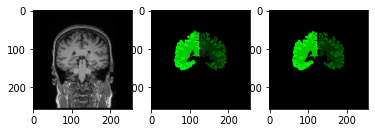

In [42]:
def check_output(i, x, y, output):
    zeros=np.zeros((256,256,1))
    x_sample=x[i].cpu()/256
    y_sample=y[i].cpu()*50/256
    output_sample=output[i].cpu()*50/256 
        
    x_sample2=np.reshape(x_sample, (256, 256, 1))
    y_sample2=np.reshape(y_sample, (256, 256, 1))
    ouput_sample2 = np.reshape(output_sample,(256,256,1))

    x_image=np.concatenate((x_sample2, x_sample2, x_sample2), axis = 2)
    y_image=np.concatenate(( zeros, y_sample2,  zeros), axis = 2)
    output_image=np.concatenate(( zeros, ouput_sample2, zeros), axis = 2)
        
    origin_image = x_image+y_image
    AI_image = x_image+output_image

    plt.subplot(131)
    plt.imshow(x_image)
    plt.subplot(132)
    plt.imshow(y_image)
    plt.subplot(133)
    plt.imshow(output_image)
        
    plt.savefig('C:/Users/BMPL/Desktop/test_{}.png'.format(i) , dpi=300)
    plt.show()
    
##==============보소싶은 레이어 넘버 입력창 ==============================##
n_layer=100
##=======================================================================##

check_output(n_layer, x_final, y_final, output_final)

In [19]:
x=np.array([[1,2,3,4,5],[1,2,3,4,5]])
y=np.array([[1,3,3,4,4],[1,3,4,5,6]])
print(x.shape)
x=TF.to_tensor(x).float()
y=TF.to_tensor(y).float()
print(x.shape)
correct_prediction = x == y
print(correct_prediction)
print(correct_prediction.float())
print(correct_prediction.float().sum())
print(correct_prediction.float().mean())


(2, 5)
torch.Size([1, 2, 5])
tensor([[[ True, False,  True,  True, False],
         [ True, False, False, False, False]]])
tensor([[[1., 0., 1., 1., 0.],
         [1., 0., 0., 0., 0.]]])
tensor(4.)
tensor(0.4000)
